In [1]:
# Usual suspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(1, '../muograph/')

![alternative text](../images/muograph_logo.png)


<h1><center>Pixel detector: tutorial</center></h1>

The `PixelDetector` class is used to simulate a pixel detector. The class takes as input 4 arguments:

- GEANT4 hits (generation level)
- Panel xy min and max position in [mm]
- Pixel width in [mm]
- Gap between 2 conscutive pixel in [mm]


Hits reconstruction is done step by step:

 - 1- **Pixel generation**: Generate an array of pixel with size `pixel_width` $w \:[\text{mm}]$, each separated by `gap` $g \: [\text{mm}]$ in $x$ and $y$.


 - 2- **Pixel triggering**: Given the *true* muon hit $(x,y,z)$, triggers the associated pixel $\text{P}_{ij}$ which satisfies:
 
$$x,y < x_{ij, max},y_{ij, max} \:\: \& \:\: x,y > x_{ij, min},y_{ij, min}$$
 
 - 3- **Hit reconstruction**: Given thje triggered pixel $\text{P}_{ij}$, computes the reconstructed hit position $(x_{rec},y_{rec})$ by smearing $\text{P}_{ij}$ position:
$$x_{rec} = x_{ij} + \mathcal{U}(-w/2,w/2)$$
$$y_{rec} = y_{ij} + \mathcal{U}(-w/2,w/2)$$

Where $\mathcal{U}$ is the continuous uniform distribution.

### WARNING

The current implementation assumes that:

- Detector panels have the **same $xy$ position**.
- Detector panels have the **same pixel array** (pixel size, gap and position).
- Muon only trigger pixels it traverses.
- Pixel array is **symmetrical in x and y** (same gap, pixel size)
- Must choose **gap** and **pixel_width** so that the pixel array fit the detector active area.


### Example

Let's create a pixel detector with size $1\times1\text{m}^2$, with xy position = (0,0), with pixel_width = $90\text{mm}$, and gap = $10\text{mm}$

In [2]:
from detector.pixel_detector import PixelDetector
from utils.read_file import hits_csv_to_tensor

hits,E = hits_csv_to_tensor(n_event=100000,
                            filename="../data/nuclear_waste_container/G4_data/9_2_2012_1M_gen.csv")

det = PixelDetector(hits=hits,
                    xy_min_max = (-500.,500.,-500.,500.),
                    pixel_width=9.9,gap=.1)


Pixel generation


DONE

 Pixel triggering


We can now draw our pixel aray configuration using the `plot_detector_panel()` method.

#### WARNING

Try not to use `plot_detector_panel()` if the number of pixels is too large! 

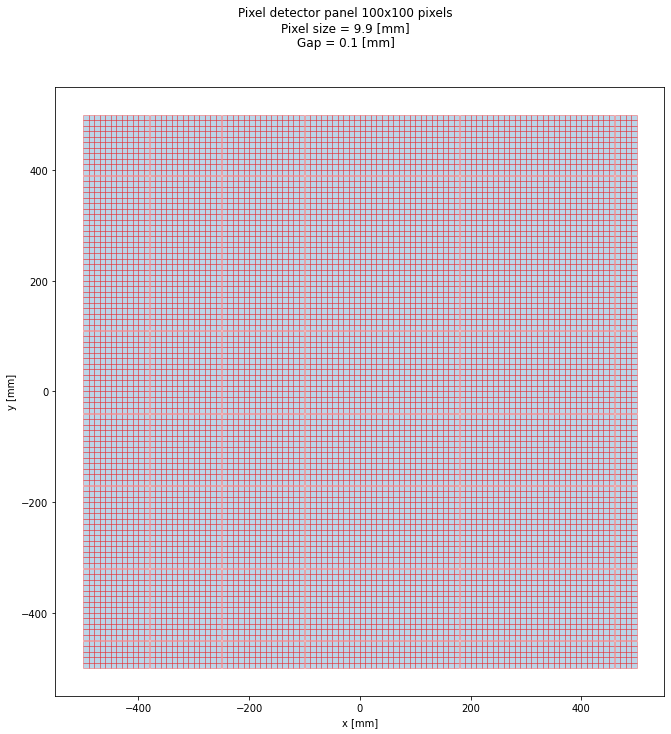

In [3]:
det.plot_detector_panel()

### Reconstructed hits


Once a triggered pixel is identified, the reconstructed position is computed as:

$$ x_{rec}\:=\:x_{ij}\:+\:\mathcal{U}(-w/2,w/2) $$

Where $x_{ij}$ the $x$ position of the triggered pixel with indices $(i,j)$, $\mathcal{U}$ is the unifrom distribution and $w$ the pixel width. Same procedure for the $y$ coordinate.

![alternative text](../images/pixel_hit_reconstruction.png)

Reconstructed hits are then stored in the `rec_hits` feature. They can now be used as an argument of the `Tracking` class! 

In [4]:
from volume.Volume_Interest import VolumeInterest
VOI = VolumeInterest(position = [0,0,835],dimension=[600,1000,300],voxel_width=20)

from tracking.Tracking import Tracking

rec_tracks = Tracking(hits=det.rec_hits, 
                      voi=VOI, 
                      E=E[det.full_co_mask.numpy()])

true_tracks = Tracking(hits=hits, 
                       voi=VOI, 
                       E=E)


Tracking in progress


Tracking done
Scattering angles computation done

Tracking in progress


Tracking done
Scattering angles computation done


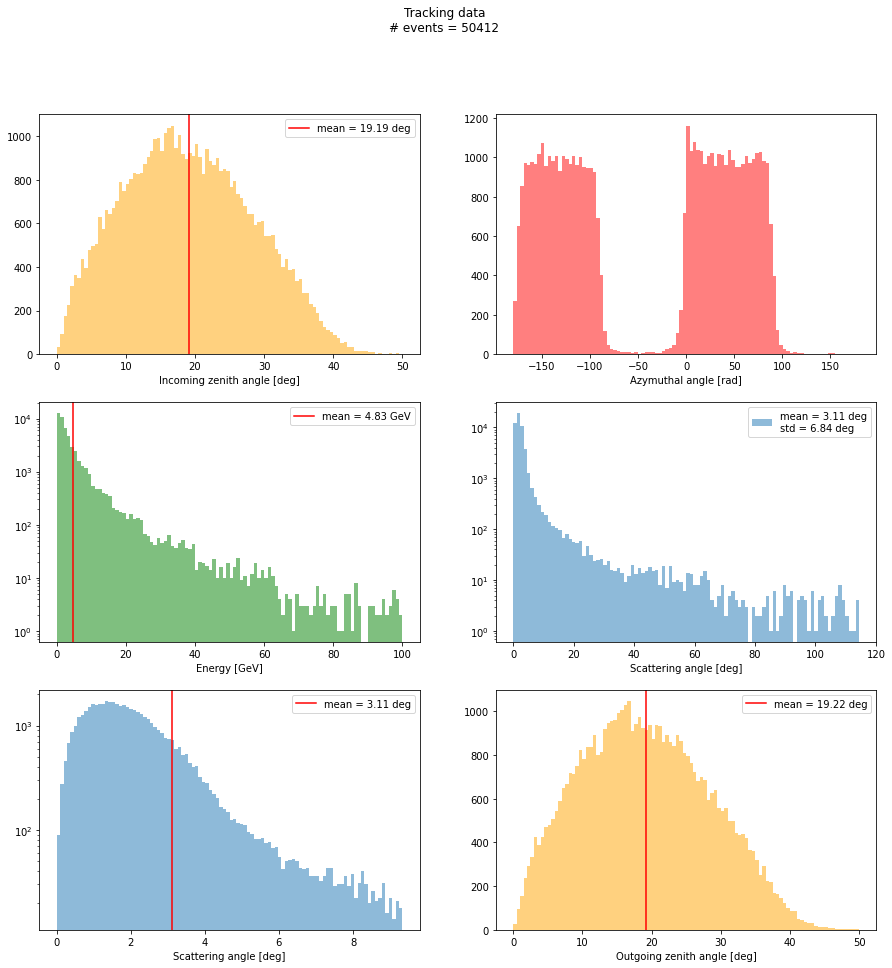

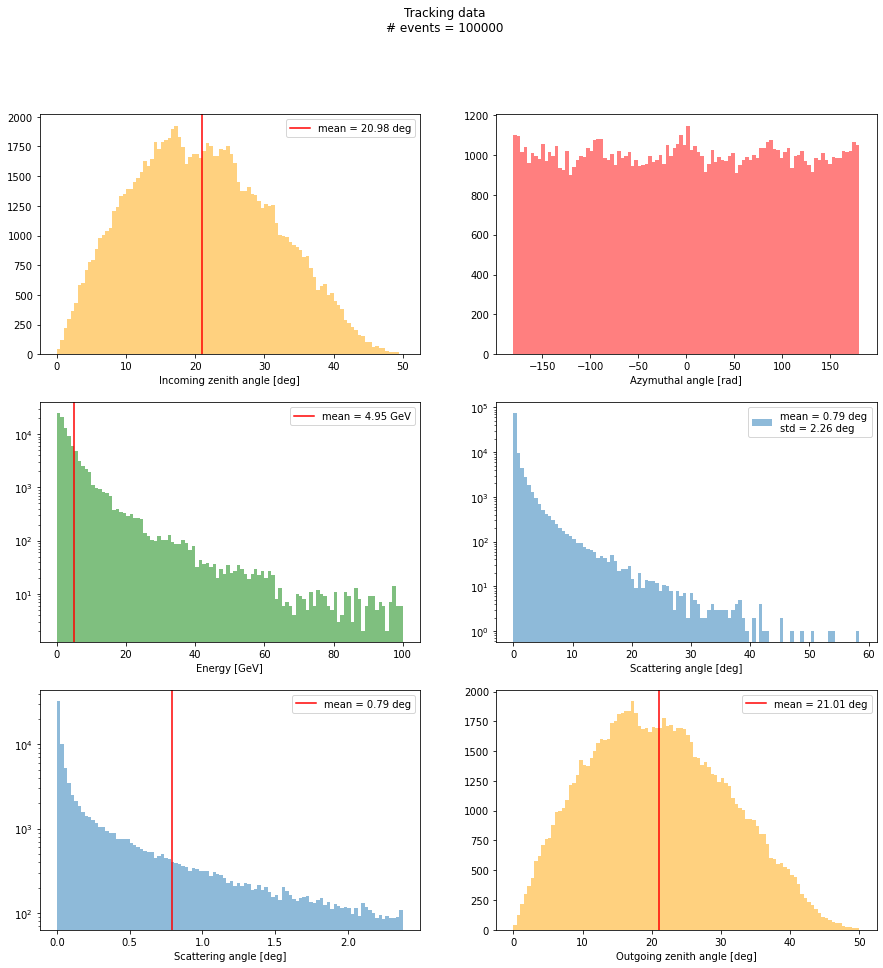

(None, None)

In [5]:
from plotting.Plotting import plot_muon_batch

plot_muon_batch(rec_tracks),plot_muon_batch(true_tracks)

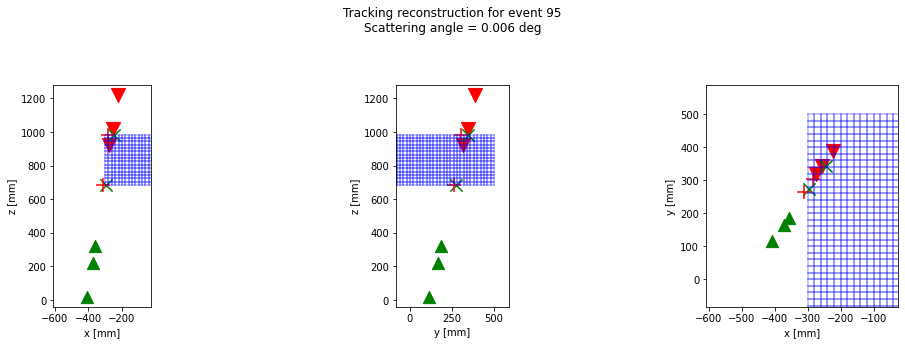

In [6]:
from plotting.Plotting import plot_event_reconstruction

plot_event_reconstruction(tracks=rec_tracks,
                         event=np.random.randint(100),hits=True)

### Angular resolution computation

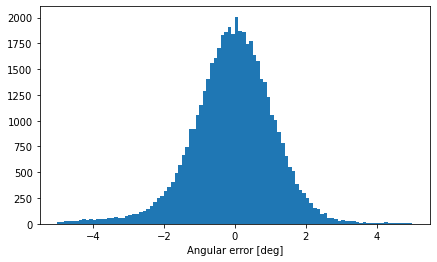

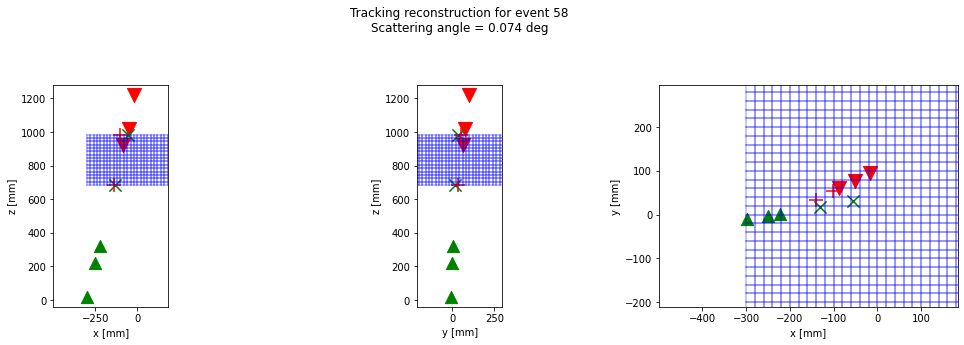

Angular resolution = 1.33 [deg]


In [9]:
import math

# Reconstructed zenith angle for incoming muon
rec_theta_in = rec_tracks.theta_in.numpy()*180/math.pi

# True zenith angle for incoming muon
true_theta_in = true_tracks.theta_in[det.full_co_mask.numpy()].numpy()*180/math.pi

# Angular error
theta_error = rec_theta_in - true_theta_in

# Plot
fig,ax=plt.subplots(figsize=(7,4))
ax.hist(theta_error,bins=100,range=(-5,5))
ax.set_xlabel("Angular error [deg]")
plt.show()

# Remove events with angular error > 10 deg
mask = (theta_error<10)&(theta_error>-10)

# Isolate event with angular error > 50 deg
events = rec_tracks.events[mask==False]
event = np.random.randint(len(events))

# Plot random event with angular error > 50 deg
plot_event_reconstruction(tracks=rec_tracks,
                         event=event,hits=True)

# Angular resolution
angular_resolution = np.std(theta_error[mask])
print('Angular resolution = {:.2f} [deg]'.format(angular_resolution))